# Learning to Iteratively Solve Routing Problems with DACT

Thank you for your interest in our work!<br> 

In this notebook, I will provide some demos on how to run and play with our DACT framework.<br> 
Hope this helps with your project :)

For any queries and potential collaboration, please email me at: yiningma@u.nus.edu<br> 
The code is free to use for personal and academic usage. For other purposes, please contact me.

The code is based on the following paper:

Yining Ma, Jingwen Li, Zhiguang Cao, Wen Song, Le Zhang, Zhenghua Chen, Jing Tang, “Learning to iteratively solve routing problems with dual-aspect collaborative transformer,” in Advances in Neural Information Processing Systems, vol. 34, 2021.

In [1]:
import os
import json
import torch
import pprint
import numpy as np
from tensorboard_logger import Logger as TbLogger
import warnings

from problems.problem_tsp import TSP
from problems.problem_vrp import CVRP
from agent.ppo import PPO
from tqdm.notebook import tqdm

## 1. load the settings for training/inference
We first load the settings for training or inference.<br>
In our code, we use the file 'options.py' and the variable 'opts' to store all hyper-parameters.

In [2]:
from options import get_options
opts = get_options('')
opts

Namespace(problem='tsp', graph_size=20, dummy_rate=0.5, step_method='2_opt', init_val_met='random', no_cuda=False, no_tb=False, show_figs=False, no_saving=False, use_assert=False, no_DDP=False, seed=1234, v_range=6.0, DACTencoder_head_num=4, DACTdecoder_head_num=4, critic_head_num=6, embedding_dim=64, hidden_dim=64, n_encode_layers=3, normalization='layer', RL_agent='ppo', gamma=0.999, K_epochs=3, eps_clip=0.1, T_train=200, n_step=4, best_cl=False, Xi_CL=0.25, batch_size=600, epoch_end=200, epoch_size=12000, lr_model=0.0001, lr_critic=3e-05, lr_decay=0.985, max_grad_norm=0.04, T_max=1500, eval_only=False, val_size=1000, val_dataset='./datasets/tsp_20_10000.pkl', val_m=1, load_path=None, resume=None, epoch_start=0, no_progress_bar=False, log_dir='logs', log_step=50, output_dir='outputs', run_name='run_name_20220530T183935', checkpoint_epochs=1, world_size=0, distributed=False, use_cuda=False, P=10000000000.0, save_dir='outputs/tsp_20/run_name_20220530T183935')

## 2. TSP-20 example

We now try TSP-20 and the '2-opt' decoder. The initial solutions are randomly initialized and we turn off the tensorboard logging and model saving functions. As an example, we train our DACT for 3 epochs (128 instances per epoch) with batch size 32. And we will validate the performance on 10 instances.

In [3]:
opts.problem = 'tsp' 
opts.graph_size = 20
opts.val_dataset='./datasets/tsp_20_10000.pkl'
opts.step_method = '2_opt'
opts.init_val_met = 'random'
opts.no_saving = True
opts.no_tb = True
opts.batch_size = 16
opts.epoch_end = 3
opts.epoch_size = 128
opts.T_max = 1000
opts.val_size = 10
tb_logger = None
opts

Namespace(problem='tsp', graph_size=20, dummy_rate=0.5, step_method='2_opt', init_val_met='random', no_cuda=False, no_tb=True, show_figs=False, no_saving=True, use_assert=False, no_DDP=False, seed=1234, v_range=6.0, DACTencoder_head_num=4, DACTdecoder_head_num=4, critic_head_num=6, embedding_dim=64, hidden_dim=64, n_encode_layers=3, normalization='layer', RL_agent='ppo', gamma=0.999, K_epochs=3, eps_clip=0.1, T_train=200, n_step=4, best_cl=False, Xi_CL=0.25, batch_size=16, epoch_end=3, epoch_size=128, lr_model=0.0001, lr_critic=3e-05, lr_decay=0.985, max_grad_norm=0.04, T_max=1000, eval_only=False, val_size=10, val_dataset='./datasets/tsp_20_10000.pkl', val_m=1, load_path=None, resume=None, epoch_start=0, no_progress_bar=False, log_dir='logs', log_step=50, output_dir='outputs', run_name='run_name_20220530T183935', checkpoint_epochs=1, world_size=0, distributed=False, use_cuda=False, P=10000000000.0, save_dir='outputs/tsp_20/run_name_20220530T183935')

In [4]:
# Optionally configure tensorboard
tb_logger = None
if not opts.no_tb and not opts.distributed:
    tb_logger = TbLogger(os.path.join(opts.log_dir, "{}_{}".format(opts.problem, 
                                                      opts.graph_size), opts.run_name))
if not opts.no_saving and not os.path.exists(opts.save_dir):
    os.makedirs(opts.save_dir)

# Save arguments so exact configuration can always be found
if not opts.no_saving:
    with open(os.path.join(opts.save_dir, "args.json"), 'w') as f:
        json.dump(vars(opts), f, indent=True)

# Set the device
opts.device = torch.device("cuda" if opts.use_cuda else "cpu")

We now get our DACT model (agent.actor) and the environment (problem) objects. In our code, 

- The problems are defined in the folder 'problems/' for TSP and CVRP

- The model architecture is defined in the folder './nets' where we put some fundamental classes in file 'graph_layers.py' and we define our actor (DACT) and critic in 'actor_network.py' and 'critic_network.py' respectively.
- The PPO class defined in file 'agent/ppo.py' stores all the procedures of training/inference, and here we name the PPO object as the 'agent'. Thus agent.actor is DACT and agent.critic is the critic.

In [5]:
def load_agent(name):
    agent = {
        'ppo': PPO,
    }.get(name, None)
    assert agent is not None, "Currently unsupported agent: {}!".format(name)
    return agent

def load_problem(name):
    problem = {
        'tsp': TSP,
        'vrp': CVRP,
    }.get(name, None)
    assert problem is not None, "Currently unsupported problem: {}!".format(name)
    return problem

# Figure out what's the problem
problem = load_problem(opts.problem)(
                        p_size = opts.graph_size,
                        step_method = opts.step_method,
                        init_val_met = opts.init_val_met,
                        with_assert = opts.use_assert,
                        P = opts.P,
                        DUMMY_RATE = opts.dummy_rate)

# Figure out the RL algorithm
agent = load_agent(opts.RL_agent)(problem.NAME, problem.size,  opts)

TSP with 20 nodes.  Do assert: False
{'Total': 280801, 'Trainable': 280801}
Distributed: False


In [6]:
print(agent.actor)

Actor(
  (embedder): EmbeddingNet(
    (embedder): Linear(in_features=2, out_features=64, bias=False)
  )
  (encoder): mySequential(
    (0): MultiHeadEncoder(
      (MHA_sublayer): MultiHeadAttentionsubLayer(
        (MHA): MultiHeadAttention()
        (Norm): Normalization()
      )
      (FFandNorm_sublayer): FFandNormsubLayer(
        (FF1): Sequential(
          (0): Linear(in_features=64, out_features=64, bias=True)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=64, out_features=64, bias=True)
        )
        (FF2): Sequential(
          (0): Linear(in_features=64, out_features=64, bias=True)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=64, out_features=64, bias=True)
        )
        (Norm): Normalization()
      )
    )
    (1): MultiHeadEncoder(
      (MHA_sublayer): MultiHeadAttentionsubLayer(
        (MHA): MultiHeadAttention()
        (Norm): Normalization()
      )
      (FFandNorm_sublayer): FFandNormsubLayer(
        (FF1): 

In [7]:
print(agent.critic)

Critic(
  (encoder): Sequential(
    (0): MultiHeadAttentionLayerforCritic(
      (0): SkipConnection(
        (module): MultiHeadAttentionOrigin()
      )
      (1): Normalization()
      (2): SkipConnection(
        (module): Sequential(
          (0): Linear(in_features=128, out_features=128, bias=True)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=128, out_features=128, bias=True)
        )
      )
      (3): Normalization()
    )
  )
  (value_head): ValueDecoder(
    (project_graph): Linear(in_features=128, out_features=128, bias=False)
    (project_node): Linear(in_features=128, out_features=128, bias=False)
    (MLP): MLP(
      (fc1): Linear(in_features=128, out_features=128, bias=True)
      (fc2): Linear(in_features=128, out_features=64, bias=True)
      (fc3): Linear(in_features=64, out_features=1, bias=True)
      (dropout): Dropout(p=0.05, inplace=False)
      (ReLU): ReLU(inplace=True)
    )
  )
)


In [8]:
agent.optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    foreach: None
    initial_lr: 0.0001
    lr: 0.0001
    maximize: False
    weight_decay: 0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    foreach: None
    initial_lr: 3e-05
    lr: 3e-05
    maximize: False
    weight_decay: 0
)

### Test before training
We first test the DACT on 10 instances with T=1k steps to see the performance of random initialization.

As can be seen, the best average costs after 1k steps of search is around 7.414

In [9]:
agent.start_inference(problem, opts.val_dataset, tb_logger)


Inference with x1 augments...
10 instances initialized.


rollout:   0%|                    | 0/1000 [00:00<?, ?it/s]                                                                                    /Users/yiningma/Documents/Research/VRP-DACT/nets/actor_network.py:160: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row_selected = pair_index // gs
rollout: 100%|████████████████████| 1000/1000 [00:05<00:00, 168.89it/s]                                                                        


 ------------------------------------------------------------
         Avg total reward:          2.734284   +- 0.340958  
          Avg step reward:          0.002734   +- 0.011168  
------------------------------------------------------------
           Avg init cost:           10.148485  +- 0.386145  
     Avg cost after 20% steps:      10.230042  +- 0.527028  
     Avg cost after 40% steps:      10.286013  +- 0.494591  
     Avg cost after 60% steps:      10.316264  +- 0.341198  
     Avg cost after 80% steps:      10.714093  +- 0.386298  
------------------------------------------------------------
   Avg best cost after 20% steps:   8.339300   +- 0.277883  
   Avg best cost after 40% steps:   7.998197   +- 0.233483  
   Avg best cost after 60% steps:   7.799273   +- 0.246264  
   Avg best cost after 80% steps:   7.747409   +- 0.228793  
        Avg final best cost:        7.414200   +- 0.242731  
------------------------------------------------------------
           Avg used ti

### Train for 3 epochs

We now perform a short training (3 epochs) for demonstration. (using CPU on my Macbook, you can use GPU on your machine:))

In [10]:
 agent.start_training(problem, opts.val_dataset, tb_logger)  




| ********************* Training epoch 0 ********************* |
Training with actor lr=1.000e-04 critic lr=3.000e-05 for run run_name_20220530T183935
128 instances initialized.


training: 100%|████████████████████| 1200/1200 [02:14<00:00,  8.92it/s]                                                                        


Inference with x1 augments...


10 instances initialized.


rollout: 100%|████████████████████| 1000/1000 [00:06<00:00, 155.74it/s]                                                                        


 ------------------------------------------------------------
         Avg total reward:          2.837795   +- 0.346943  
          Avg step reward:          0.002838   +- 0.011474  
------------------------------------------------------------
           Avg init cost:           10.148485  +- 0.386145  
     Avg cost after 20% steps:      10.367243  +- 0.325827  
     Avg cost after 40% steps:      10.444877  +- 0.272816  
     Avg cost after 60% steps:      10.444994  +- 0.385916  
     Avg cost after 80% steps:      10.373947  +- 0.407691  
------------------------------------------------------------
   Avg best cost after 20% steps:   8.148291   +- 0.245275  
   Avg best cost after 40% steps:   7.679384   +- 0.244808  
   Avg best cost after 60% steps:   7.527102   +- 0.261678  
   Avg best cost after 80% steps:   7.402348   +- 0.289529  
        Avg final best cost:        7.310689   +- 0.271949  
------------------------------------------------------------
           Avg used ti

128 instances initialized.


training: 100%|████████████████████| 1200/1200 [02:15<00:00,  8.84it/s]                                                                        


Inference with x1 augments...


10 instances initialized.


rollout: 100%|████████████████████| 1000/1000 [00:06<00:00, 154.92it/s]                                                                        


 ------------------------------------------------------------
         Avg total reward:          3.199739   +- 0.287414  
          Avg step reward:          0.003200   +- 0.012141  
------------------------------------------------------------
           Avg init cost:           10.148485  +- 0.386145  
     Avg cost after 20% steps:      9.275047   +- 0.374984  
     Avg cost after 40% steps:      9.933675   +- 0.295993  
     Avg cost after 60% steps:      9.714057   +- 0.399583  
     Avg cost after 80% steps:      10.167959  +- 0.559399  
------------------------------------------------------------
   Avg best cost after 20% steps:   7.652226   +- 0.268861  
   Avg best cost after 40% steps:   7.315093   +- 0.284983  
   Avg best cost after 60% steps:   7.086202   +- 0.303867  
   Avg best cost after 80% steps:   7.026217   +- 0.289957  
        Avg final best cost:        6.948744   +- 0.283791  
------------------------------------------------------------
           Avg used ti

128 instances initialized.


training: 100%|████████████████████| 1200/1200 [02:15<00:00,  8.84it/s]                                                                        


Inference with x1 augments...


10 instances initialized.


rollout: 100%|████████████████████| 1000/1000 [00:06<00:00, 151.72it/s]                                                                        


 ------------------------------------------------------------
         Avg total reward:          4.024657   +- 0.363000  
          Avg step reward:          0.004025   +- 0.014728  
------------------------------------------------------------
           Avg init cost:           10.148485  +- 0.386145  
     Avg cost after 20% steps:      9.552496   +- 0.446404  
     Avg cost after 40% steps:      9.051730   +- 0.195298  
     Avg cost after 60% steps:      8.658719   +- 0.438311  
     Avg cost after 80% steps:      8.972696   +- 0.315070  
------------------------------------------------------------
   Avg best cost after 20% steps:   6.679961   +- 0.183774  
   Avg best cost after 40% steps:   6.433897   +- 0.160505  
   Avg best cost after 60% steps:   6.274650   +- 0.172030  
   Avg best cost after 80% steps:   6.184441   +- 0.186275  
        Avg final best cost:        6.123827   +- 0.181210  
------------------------------------------------------------
           Avg used ti

### Test after short-training
We then test the DACT on the same 10 instances with T=1k steps to see the performance after the above short training.

As can be seen, the best average cost after 1k steps of search is around 6.123 which shows some imporvement. But off cause such toy training with the small-scale training data is not enough for the Transformer model to get good results. Please follow the hyper-parameters in our paper for actually training.

In [11]:
agent.start_inference(problem, opts.val_dataset, tb_logger)


Inference with x1 augments...
10 instances initialized.


rollout: 100%|████████████████████| 1000/1000 [00:06<00:00, 156.91it/s]                                                                        


 ------------------------------------------------------------
         Avg total reward:          4.024657   +- 0.363000  
          Avg step reward:          0.004025   +- 0.014728  
------------------------------------------------------------
           Avg init cost:           10.148485  +- 0.386145  
     Avg cost after 20% steps:      9.552496   +- 0.446404  
     Avg cost after 40% steps:      9.051730   +- 0.195298  
     Avg cost after 60% steps:      8.658719   +- 0.438311  
     Avg cost after 80% steps:      8.972696   +- 0.315070  
------------------------------------------------------------
   Avg best cost after 20% steps:   6.679961   +- 0.183774  
   Avg best cost after 40% steps:   6.433897   +- 0.160505  
   Avg best cost after 60% steps:   6.274650   +- 0.172030  
   Avg best cost after 80% steps:   6.184441   +- 0.186275  
        Avg final best cost:        6.123827   +- 0.181210  
------------------------------------------------------------
           Avg used ti

### Load the pre-trained model to test
We now load the pre-trained model to see the real performance of our DACT.

In [12]:
opts.load_path = './pretrained/tsp20-epoch-199.pt'

assert opts.load_path is None or opts.resume is None, "Only one of load path and resume can be given"
load_path = opts.load_path if opts.load_path is not None else opts.resume
if load_path is not None:
    agent.load(load_path)

agent.start_inference(problem, opts.val_dataset, tb_logger)

 [*] Loading data from ./pretrained/tsp20-epoch-199.pt

Inference with x1 augments...
10 instances initialized.


rollout: 100%|████████████████████| 1000/1000 [00:06<00:00, 150.57it/s]                                                                        


 ------------------------------------------------------------
         Avg total reward:          6.428893   +- 0.361167  
          Avg step reward:          0.006429   +- 0.018263  
------------------------------------------------------------
           Avg init cost:           10.148485  +- 0.386145  
     Avg cost after 20% steps:      4.526318   +- 0.284380  
     Avg cost after 40% steps:      4.206199   +- 0.098675  
     Avg cost after 60% steps:      4.927659   +- 0.399352  
     Avg cost after 80% steps:      4.811302   +- 0.257685  
------------------------------------------------------------
   Avg best cost after 20% steps:   3.721851   +- 0.081973  
   Avg best cost after 40% steps:   3.719591   +- 0.082467  
   Avg best cost after 60% steps:   3.719591   +- 0.082467  
   Avg best cost after 80% steps:   3.719591   +- 0.082467  
        Avg final best cost:        3.719591   +- 0.082467  
------------------------------------------------------------
           Avg used ti

## 3. CVRP example

We now try CVRP. Different from TSP, we consider the dummy depots to handle the sub-tours in CVRP (see our Appendix in https://arxiv.org/abs/2110.02544 for detailed explanation).

In [13]:
opts.problem = 'vrp' 
opts.step_method = '2_opt'
opts.init_val_met = 'random'
opts.no_saving = True
opts.no_tb = True
opts.T_max = 1000
opts.val_size = 10
tb_logger = None
opts

Namespace(problem='vrp', graph_size=20, dummy_rate=0.5, step_method='2_opt', init_val_met='random', no_cuda=False, no_tb=True, show_figs=False, no_saving=True, use_assert=False, no_DDP=False, seed=1234, v_range=6.0, DACTencoder_head_num=4, DACTdecoder_head_num=4, critic_head_num=6, embedding_dim=64, hidden_dim=64, n_encode_layers=3, normalization='layer', RL_agent='ppo', gamma=0.999, K_epochs=3, eps_clip=0.1, T_train=200, n_step=4, best_cl=False, Xi_CL=0.25, batch_size=16, epoch_end=3, epoch_size=128, lr_model=0.0001, lr_critic=3e-05, lr_decay=0.985, max_grad_norm=0.04, T_max=1000, eval_only=False, val_size=10, val_dataset='./datasets/tsp_20_10000.pkl', val_m=1, load_path='./pretrained/tsp20-epoch-199.pt', resume=None, epoch_start=0, no_progress_bar=False, log_dir='logs', log_step=50, output_dir='outputs', run_name='run_name_20220530T183935', checkpoint_epochs=1, world_size=0, distributed=False, use_cuda=False, P=10000000000.0, save_dir='outputs/tsp_20/run_name_20220530T183935', device

### Load the pre-trained model to test
We now load the pre-trained model to see the performance.

#### CVRP-20
Note that we cosider 10 dummy depots for CVRP-20. So the dummy rate is 0.5 (0.5*20=10).

In [14]:
opts.graph_size = 20
opts.dummy_rate = 0.5
opts.val_dataset='./datasets/cvrp_20_10000.pkl'

problem = load_problem(opts.problem)(
                        p_size = opts.graph_size,
                        step_method = opts.step_method,
                        init_val_met = opts.init_val_met,
                        with_assert = opts.use_assert,
                        P = opts.P,
                        DUMMY_RATE = opts.dummy_rate)

agent = load_agent(opts.RL_agent)(problem.NAME, problem.size,  opts)

opts.load_path = 'pretrained/cvrp20-epoch-191.pt'

assert opts.load_path is None or opts.resume is None, "Only one of load path and resume can be given"
load_path = opts.load_path if opts.load_path is not None else opts.resume
if load_path is not None:
    agent.load(load_path)

agent.start_inference(problem, opts.val_dataset, tb_logger)

CVRP with 20 nodes and 10 dummy depot.
  Do assert: False
{'Total': 281121, 'Trainable': 281121}
Distributed: False
 [*] Loading data from pretrained/cvrp20-epoch-191.pt

Inference with x1 augments...
10 instances initialized.


rollout: 100%|████████████████████| 1000/1000 [00:10<00:00, 96.34it/s]                                                                         


 ------------------------------------------------------------
         Avg total reward:          6.445018   +- 0.455971  
          Avg step reward:          0.006445   +- 0.020147  
------------------------------------------------------------
           Avg init cost:           12.586521  +- 0.517959  
     Avg cost after 20% steps:      6.379748   +- 0.317011  
     Avg cost after 40% steps:      6.916287   +- 0.504030  
     Avg cost after 60% steps:      6.666201   +- 0.359995  
     Avg cost after 80% steps:      6.756374   +- 0.337390  
------------------------------------------------------------
   Avg best cost after 20% steps:   6.165843   +- 0.324155  
   Avg best cost after 40% steps:   6.158087   +- 0.324648  
   Avg best cost after 60% steps:   6.142027   +- 0.327137  
   Avg best cost after 80% steps:   6.141504   +- 0.327112  
        Avg final best cost:        6.141503   +- 0.327112  
------------------------------------------------------------
           Avg used ti

#### CVRP-50
Note that we cosider 20 dummy depots for CVRP-50. So the dummy rate is 0.4 (0.4*50=20).

In [15]:
opts.graph_size = 50
opts.dummy_rate = 0.4
opts.val_dataset='./datasets/cvrp_50_10000.pkl'

problem = load_problem(opts.problem)(
                        p_size = opts.graph_size,
                        step_method = opts.step_method,
                        init_val_met = opts.init_val_met,
                        with_assert = opts.use_assert,
                        P = opts.P,
                        DUMMY_RATE = opts.dummy_rate)

agent = load_agent(opts.RL_agent)(problem.NAME, problem.size,  opts)

opts.load_path = 'pretrained/cvrp50-epoch-197.pt'

assert opts.load_path is None or opts.resume is None, "Only one of load path and resume can be given"
load_path = opts.load_path if opts.load_path is not None else opts.resume
if load_path is not None:
    agent.load(load_path)

agent.start_inference(problem, opts.val_dataset, tb_logger)

CVRP with 50 nodes and 20 dummy depot.
  Do assert: False
{'Total': 281121, 'Trainable': 281121}
Distributed: False
 [*] Loading data from pretrained/cvrp50-epoch-197.pt

Inference with x1 augments...
10 instances initialized.


rollout: 100%|████████████████████| 1000/1000 [00:22<00:00, 43.87it/s]                                                                         


 ------------------------------------------------------------
         Avg total reward:          18.863953  +- 0.771276  
          Avg step reward:          0.018864   +- 0.034527  
------------------------------------------------------------
           Avg init cost:           29.390284  +- 1.007939  
     Avg cost after 20% steps:      11.117811  +- 0.519719  
     Avg cost after 40% steps:      11.367609  +- 0.542217  
     Avg cost after 60% steps:      11.128602  +- 0.435248  
     Avg cost after 80% steps:      10.895082  +- 0.411694  
------------------------------------------------------------
   Avg best cost after 20% steps:   10.786608  +- 0.452383  
   Avg best cost after 40% steps:   10.636443  +- 0.430322  
   Avg best cost after 60% steps:   10.539412  +- 0.414014  
   Avg best cost after 80% steps:   10.537088  +- 0.413605  
        Avg final best cost:        10.526330  +- 0.415369  
------------------------------------------------------------
           Avg used ti

#### CVRP-100
Note that we cosider 20 dummy depots for CVRP-100. So the dummy rate is 0.2 (0.2*100=20).

In [16]:
opts.graph_size = 100
opts.dummy_rate = 0.2
opts.val_dataset='./datasets/cvrp_100_10000.pkl'

problem = load_problem(opts.problem)(
                        p_size = opts.graph_size,
                        step_method = opts.step_method,
                        init_val_met = opts.init_val_met,
                        with_assert = opts.use_assert,
                        P = opts.P,
                        DUMMY_RATE = opts.dummy_rate)

agent = load_agent(opts.RL_agent)(problem.NAME, problem.size,  opts)

opts.load_path = 'pretrained/cvrp100-epoch-198.pt'

assert opts.load_path is None or opts.resume is None, "Only one of load path and resume can be given"
load_path = opts.load_path if opts.load_path is not None else opts.resume
if load_path is not None:
    agent.load(load_path)

agent.start_inference(problem, opts.val_dataset, tb_logger)

CVRP with 100 nodes and 20 dummy depot.
  Do assert: False
{'Total': 281121, 'Trainable': 281121}
Distributed: False
 [*] Loading data from pretrained/cvrp100-epoch-198.pt

Inference with x1 augments...
10 instances initialized.


rollout: 100%|████████████████████| 1000/1000 [00:38<00:00, 25.84it/s]                                                                         


 ------------------------------------------------------------
         Avg total reward:          40.455200  +- 0.553329  
          Avg step reward:          0.040455   +- 0.049510  
------------------------------------------------------------
           Avg init cost:           56.810841  +- 0.976980  
     Avg cost after 20% steps:      18.063940  +- 0.774899  
     Avg cost after 40% steps:      17.388454  +- 0.793675  
     Avg cost after 60% steps:      17.239515  +- 0.788243  
     Avg cost after 80% steps:      17.262287  +- 0.617114  
------------------------------------------------------------
   Avg best cost after 20% steps:   17.619732  +- 0.712923  
   Avg best cost after 40% steps:   16.817329  +- 0.655099  
   Avg best cost after 60% steps:   16.490788  +- 0.602953  
   Avg best cost after 80% steps:   16.369129  +- 0.605830  
        Avg final best cost:        16.355635  +- 0.607116  
------------------------------------------------------------
           Avg used ti

## 4. Look inside the data structure (Taking TSP-20 as an example)

If you want to modify DACT for your own task, I bet this part is important and helpful for you to understand the current data structure of the DACT :)

### Switch back to TSP-20
Let's first switch back to TSP-20 and load the pre-trained DACT model.

In [17]:
opts.problem = 'tsp' 
opts.graph_size = 20
opts.val_dataset='./datasets/tsp_20_10000.pkl'
opts.step_method = '2_opt'
opts.init_val_met = 'random'
opts.no_saving = True
opts.no_tb = True
opts.T_max = 1000
opts.val_size = 10
tb_logger = None

problem = load_problem(opts.problem)(
                        p_size = opts.graph_size,
                        step_method = opts.step_method,
                        init_val_met = opts.init_val_met,
                        with_assert = opts.use_assert,
                        P = opts.P,
                        DUMMY_RATE = opts.dummy_rate)

agent = load_agent(opts.RL_agent)(problem.NAME, problem.size,  opts)

opts.load_path = './pretrained/tsp20-epoch-199.pt'

assert opts.load_path is None or opts.resume is None, "Only one of load path and resume can be given"
load_path = opts.load_path if opts.load_path is not None else opts.resume
if load_path is not None:
    agent.load(load_path)


TSP with 20 nodes.  Do assert: False
{'Total': 280801, 'Trainable': 280801}
Distributed: False
 [*] Loading data from ./pretrained/tsp20-epoch-199.pt


### initilize 10 instances and show the first one

In [18]:
from torch.utils.data import DataLoader
from problems.problem_tsp import TSPDataset
dataset = TSPDataset(size = 20, num_samples = 10)
batch = next(iter(DataLoader(dataset, batch_size=10)))
coordinates_first = batch['coordinates'][0]
print(coordinates_first)

10 instances initialized.
tensor([[0.1990, 0.0370],
        [0.8674, 0.6153],
        [0.7322, 0.5163],
        [0.1122, 0.9976],
        [0.4591, 0.6927],
        [0.4451, 0.7435],
        [0.5121, 0.2444],
        [0.3744, 0.6207],
        [0.6183, 0.5285],
        [0.1721, 0.9431],
        [0.1924, 0.2713],
        [0.2972, 0.8603],
        [0.5501, 0.9708],
        [0.5080, 0.7422],
        [0.2836, 0.3816],
        [0.2689, 0.0147],
        [0.7036, 0.1035],
        [0.7376, 0.9486],
        [0.1277, 0.8159],
        [0.8329, 0.7074]])


### Get initial solutions ramdomly

#### **important note !!!!**

**Please note that in our implementation, the solution is stored in a linked list format. Here, if rec[i] = j, it means the node i is connected to node j, i.e., edge i-j is in the solution. For example, if edge 0-1, edge 1-5, edge 2-10 are in the solution, so we have rec[0]=1, rec[1]=5 and rec[2]=10.**

In [19]:
rec = problem.get_initial_solutions(batch)
print(rec[0])

tensor([14, 12,  7, 15, 16,  6,  1, 11, 19,  5, 13, 18,  8, 17,  3,  2,  0,  4,
         9, 10])


Let's plot the initial solution for the first instance to illustrate the linked list format.

In [20]:
import torch
from matplotlib import pyplot as plt
from problems.problem_tsp import get_real_seq

def plot_tour(rec, coordinates, dpi = 300):
    plt.figure(figsize=(8,6))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.axis([-0.05, 1.05]*2)
    # plot the nodes
    plt.scatter(coordinates[:,0], coordinates[:,1], marker = 'H', s = 55, c = 'blue', zorder = 2)
    # plot the tour
    real_seq = get_real_seq(rec.unsqueeze(0))
    real_seq_coordinates = coordinates.gather(0,real_seq[0].unsqueeze(1).repeat(1,2))
    real_seq_coordinates = torch.cat((real_seq_coordinates, real_seq_coordinates[:1]),0)
    plt.plot(real_seq_coordinates[:,0], real_seq_coordinates[:,1], color = 'black', zorder = 1)
    # mark node
    for i,txt in enumerate(range(rec.size(0))):
        plt.annotate(txt,(coordinates[i,0]+0.01, coordinates[i,1]+0.01),)
    
    
    plt.show()

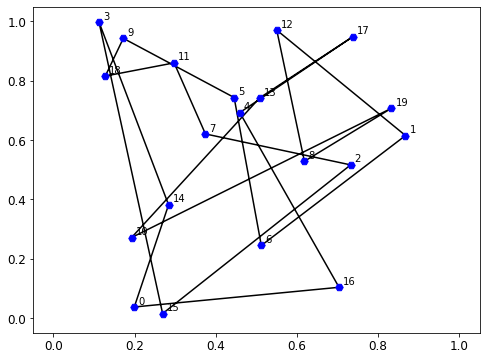

Linked list format (rec variable):
 tensor([14, 12,  7, 15, 16,  6,  1, 11, 19,  5, 13, 18,  8, 17,  3,  2,  0,  4,
         9, 10])

Here, the linked list format means:
edge 0-14 is in the solution
edge 1-12 is in the solution
edge 2-7 is in the solution
edge 3-15 is in the solution
edge 4-16 is in the solution
edge 5-6 is in the solution
edge 6-1 is in the solution
edge 7-11 is in the solution
edge 8-19 is in the solution
edge 9-5 is in the solution
edge 10-13 is in the solution
edge 11-18 is in the solution
edge 12-8 is in the solution
edge 13-17 is in the solution
edge 14-3 is in the solution
edge 15-2 is in the solution
edge 16-0 is in the solution
edge 17-4 is in the solution
edge 18-9 is in the solution
edge 19-10 is in the solution

Real solution after decoding (node visited in sequence):
 tensor([ 0, 14,  3, 15,  2,  7, 11, 18,  9,  5,  6,  1, 12,  8, 19, 10, 13, 17,
         4, 16])


In [21]:
plot_tour(rec[0], coordinates_first)
print('Linked list format (rec variable):\n', rec[0])
print('\nHere, the linked list format means:')
for i in range(20):
    print(f'edge {i}-{rec[0,i]} is in the solution')
print('\nReal solution after decoding (node visited in sequence):\n', get_real_seq(rec)[0])

### Use pre-trained DACT to solve this mini-batch

The codes here are dapated from the 'agent.rollout' function defined in line 135 of file 'agent/ppo.py'

In [25]:
# get initial cost
obj = problem.get_costs(batch, rec)
best_solution = rec.clone()

# prepare the features
batch_feature = problem.input_feature_encoding(batch)
solving_state = torch.zeros((batch_feature.size(0),1), device = opts.device).long()
action = None

for t in tqdm(range(5000), disable = opts.no_progress_bar, 
              desc = 'rollout', bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}'):

     # pass through model
    action = agent.actor(problem,
                          batch_feature,
                          rec,
                          action,
                          do_sample = True)[0]

    # state trasition
    rec, rewards, obj, solving_state = problem.step(batch, 
                                                    rec, 
                                                    action, 
                                                    obj, 
                                                    solving_state, 
                                                    best_solution = best_solution)

    # record informations
    best_solution[rewards > 0] = rec[rewards > 0]
bv = obj[:,-1].reshape(10, 1).min(1)[0]

rollout:   0%|                    | 0/5000 [00:00<?, ?it/s]

### show the improved solution of the first instance

In [26]:
print('best cost:', bv[0])
print('best rec found:', best_solution[0])

best cost: tensor(3.7696)
best rec found: tensor([10,  2,  8,  9, 13, 11, 16,  4,  6, 12, 14, 18, 17,  5,  7,  0, 15, 19,
         3,  1])


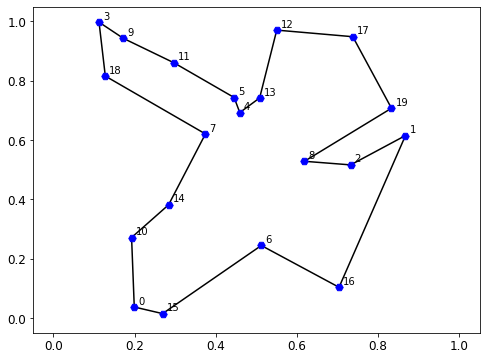

Linked list format (rec variable):
 tensor([15,  2,  8, 18,  5, 11, 16, 14, 19,  3,  0,  9, 13,  4, 10,  6,  1, 12,
         7, 17])

Here, the linked list format means:
edge 0-15 is in the solution
edge 1-2 is in the solution
edge 2-8 is in the solution
edge 3-18 is in the solution
edge 4-5 is in the solution
edge 5-11 is in the solution
edge 6-16 is in the solution
edge 7-14 is in the solution
edge 8-19 is in the solution
edge 9-3 is in the solution
edge 10-0 is in the solution
edge 11-9 is in the solution
edge 12-13 is in the solution
edge 13-4 is in the solution
edge 14-10 is in the solution
edge 15-6 is in the solution
edge 16-1 is in the solution
edge 17-12 is in the solution
edge 18-7 is in the solution
edge 19-17 is in the solution

Real solution after decoding (node visited in sequence):
 tensor([ 0, 15,  6, 16,  1,  2,  8, 19, 17, 12, 13,  4,  5, 11,  9,  3, 18,  7,
        14, 10])


In [27]:
plot_tour(rec[0], coordinates_first)
print('Linked list format (rec variable):\n', rec[0])
print('\nHere, the linked list format means:')
for i in range(20):
    print(f'edge {i}-{rec[0,i]} is in the solution')
print('\nReal solution after decoding (node visited in sequence):\n', get_real_seq(rec)[0])